In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
from scipy.stats import geom
from scipy.stats import betabinom
from scipy.optimize import nnls

In [62]:
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c100m"

n_tests = 10
n_runs = 3
n_mut = 100
alpha_h, beta_h = 3, 3
dropout_prob = 0.3
dropout_direction = 0.5
error_rate = 0.05
overdispersion = 10
overdispersion_h = alpha_h + beta_h

freq_R = np.zeros((n_tests, n_mut))
freq_H = np.zeros((n_tests, n_mut))
freq_A = np.zeros((n_tests, n_mut))

for test in range(n_tests):
    genotype_path = os.path.join(path, "genotype", f"genotype_{test}.txt")
    genotype_gt = np.loadtxt(genotype_path, dtype=str)
    n_cells, n_mut = genotype_gt.shape

    for j in range(n_mut):
        column = genotype_gt[:, j]
        freq_R[test, j] = np.sum(column == "R") / n_cells
        freq_H[test, j] = np.sum(column == "H") / n_cells
        freq_A[test, j] = np.sum(column == "A") / n_cells

In [63]:
def genotype_distributions_for_coverage(cov, alpha_H=alpha_h, beta_H=beta_h):
    alpha_R = error_rate * overdispersion
    beta_R = overdispersion - alpha_R
    alpha_A = (1 - error_rate) * overdispersion
    beta_A = overdispersion - alpha_A

    x = np.arange(cov + 1)
    P_R = betabinom.pmf(x, cov, alpha_R, beta_R)
    P_H = (1 - dropout_prob) * betabinom.pmf(x, cov, alpha_H, beta_H) + \
          dropout_prob * ((1 - dropout_direction) * betabinom.pmf(x, cov, alpha_R, beta_R) +
                          dropout_direction * betabinom.pmf(x, cov, alpha_A, beta_A))
    P_A = betabinom.pmf(x, cov, alpha_A, beta_A)
    return np.vstack([P_R, P_H, P_A]).T  # shape (cov+1, 3)

def estimate_frequencies_binned(n_ref_matrix, n_alt_matrix, n_bins=3, min_cells_per_bin=5, min_coverage=5):
    """Non-Negative Least Squares optimization to estimate genotype frequencies for coverage bins."""

    m, n = n_ref_matrix.shape
    freq_R = np.zeros(n)
    freq_H = np.zeros(n)
    freq_A = np.zeros(n)

    for j in range(n):
        ref = n_ref_matrix[:, j]
        alt = n_alt_matrix[:, j]
        total = ref + alt

        # Keep only cells with higher coverage
        valid_mask = total > min_coverage
        total_valid = total[valid_mask]
        alt_valid = alt[valid_mask]

        if len(total_valid) < n_bins * min_cells_per_bin:
            print("Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage")
            continue

        # Sort by coverage
        sort_idx = np.argsort(total_valid)
        total_sorted = total_valid[sort_idx]
        alt_sorted = alt_valid[sort_idx]

        # Compute bin edges for roughly equal-sized bins
        bin_edges = np.linspace(0, len(total_sorted), n_bins + 1, dtype=int)

        weighted_estimates = []

        for i in range(n_bins):
            start, end = bin_edges[i], bin_edges[i+1]
            if end - start < min_cells_per_bin:
                continue

            t_bin = total_sorted[start:end]
            a_bin = alt_sorted[start:end]
            cov_median = int(np.median(t_bin))
            if cov_median == 0:
                continue

            # Normalize alt counts to median coverage
            norm_alt = np.round(a_bin * cov_median / t_bin).astype(int)
            norm_alt = np.clip(norm_alt, 0, cov_median)

            # Histogram of alt counts
            hist, _ = np.histogram(norm_alt, bins=np.arange(cov_median + 2), density=True)
            model_matrix = genotype_distributions_for_coverage(cov_median)

            weights, _ = nnls(model_matrix, hist)
            weights_sum = weights.sum()
            if weights_sum == 0:
                continue
            weights /= weights_sum
            weighted_estimates.append((len(norm_alt), weights))

        if weighted_estimates:
            total_weight = sum(w for w, _ in weighted_estimates)
            avg = sum(w * f for w, f in weighted_estimates) / total_weight
            freq_R[j], freq_H[j], freq_A[j] = avg

    return freq_R, freq_H, freq_A

estimated_freq_R = np.zeros((n_tests, n_mut))
estimated_freq_H = np.zeros((n_tests, n_mut))
estimated_freq_A = np.zeros((n_tests, n_mut))

for test in range(n_tests):
    ref_path = os.path.join(path, "ref", f"ref_{test}.txt")
    alt_path = os.path.join(path, "alt", f"alt_{test}.txt")
    ref_matrix = np.loadtxt(ref_path, dtype=int)
    alt_matrix = np.loadtxt(alt_path, dtype=int)

    # Estimate frequencies
    est_freq_R, est_freq_H, est_freq_A = estimate_frequencies_binned(ref_matrix, alt_matrix)
    estimated_freq_R[test] = est_freq_R
    estimated_freq_H[test] = est_freq_H
    estimated_freq_A[test] = est_freq_A

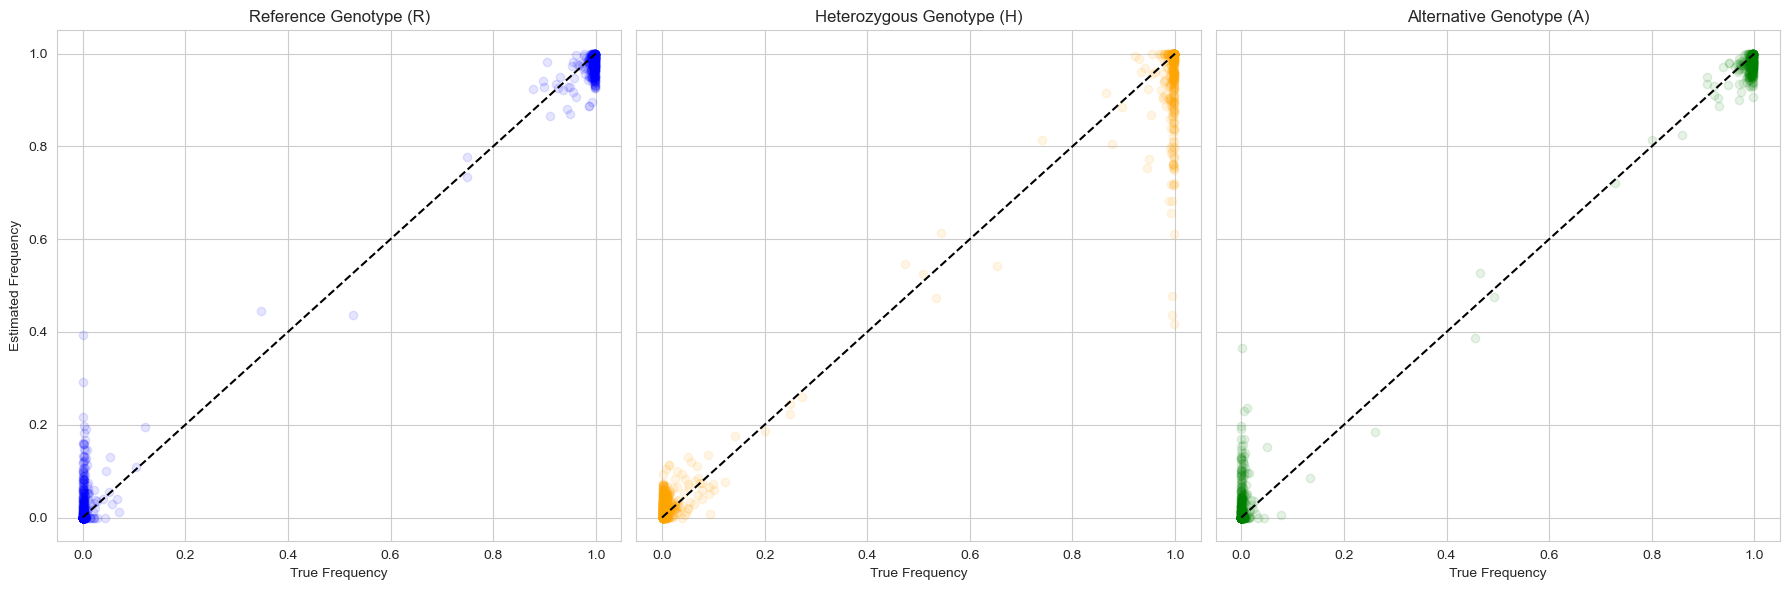

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(freq_R, estimated_freq_R, alpha=0.1, label="R", color='blue')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("Reference Genotype (R)")
axes[0].set_xlabel("True Frequency")
axes[0].set_ylabel("Estimated Frequency")

axes[1].scatter(freq_H, estimated_freq_H, alpha=0.1, label="H", color='orange')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("Heterozygous Genotype (H)")
axes[1].set_xlabel("True Frequency")

axes[2].scatter(freq_A, estimated_freq_A, alpha=0.1, label="A", color='green')
axes[2].plot([0, 1], [0, 1], 'k--')
axes[2].set_title("Alternative Genotype (A)")
axes[2].set_xlabel("True Frequency")

plt.tight_layout()
plt.show()

In [65]:
sample_name = "mm16"

real_data_path = rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\{sample_name}"

ref_path = os.path.join(real_data_path, f"ref.csv")
alt_path = os.path.join(real_data_path, f"alt.csv")

ref = np.array(pd.read_csv(ref_path))[:,1:].astype(int)
alt = np.array(pd.read_csv(alt_path))[:,1:].astype(int)

est_freq_R, est_freq_H, est_freq_A = estimate_frequencies_binned(ref, alt)

Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage
Not enough data to make reliable bins, reduce the number of bins, min_cells_per_bin or min coverage


In [66]:
selected = []
gt1_list = []
gt2_list = []
not_selected = []

for e in range(len(est_freq_R)):
    r, h, a = est_freq_R[e], est_freq_H[e], est_freq_A[e]

    if 0.05 < r < 0.95:
        # Create genotype-frequency pairs
        freqs = {'R': r, 'H': h, 'A': a}

        # Sort by frequency, descending
        sorted_genotypes = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
        gt1, gt1_val = sorted_genotypes[0]
        gt2, gt2_val = sorted_genotypes[1]

        # Enforce constraint: no direct R-A transitions
        if {'R', 'A'} == {gt1, gt2}:
            gt2 = 'H'
            gt2_val = freqs['H']

        print(f"R: {r:.3f}, H: {h:.3f}, A: {a:.3f} | gt1: {gt1}, gt2: {gt2}")
        selected.append(e)
        gt1_list.append(gt1)
        gt2_list.append(gt2)

    else:
        not_selected.append(e)
        freqs = {'R': r, 'H': h, 'A': a}
        max_genotype = max(freqs, key=freqs.get)
        not_selected.append(max_genotype)

R: 0.187, H: 0.000, A: 0.813 | gt1: A, gt2: H
R: 0.876, H: 0.000, A: 0.124 | gt1: R, gt2: H
R: 0.911, H: 0.000, A: 0.089 | gt1: R, gt2: H
R: 0.890, H: 0.029, A: 0.081 | gt1: R, gt2: H
R: 0.790, H: 0.000, A: 0.210 | gt1: R, gt2: H
R: 0.264, H: 0.272, A: 0.464 | gt1: A, gt2: H
R: 0.309, H: 0.180, A: 0.511 | gt1: A, gt2: H
R: 0.325, H: 0.266, A: 0.409 | gt1: A, gt2: H
R: 0.260, H: 0.366, A: 0.374 | gt1: A, gt2: H
R: 0.235, H: 0.394, A: 0.371 | gt1: H, gt2: A
R: 0.455, H: 0.203, A: 0.342 | gt1: R, gt2: H
R: 0.401, H: 0.263, A: 0.336 | gt1: R, gt2: H
R: 0.477, H: 0.080, A: 0.443 | gt1: R, gt2: H
R: 0.212, H: 0.026, A: 0.762 | gt1: A, gt2: H
R: 0.882, H: 0.000, A: 0.118 | gt1: R, gt2: H
R: 0.938, H: 0.000, A: 0.062 | gt1: R, gt2: H
R: 0.297, H: 0.367, A: 0.336 | gt1: H, gt2: A
R: 0.068, H: 0.913, A: 0.019 | gt1: H, gt2: R
R: 0.286, H: 0.196, A: 0.517 | gt1: A, gt2: H
R: 0.092, H: 0.826, A: 0.082 | gt1: H, gt2: R
R: 0.630, H: 0.138, A: 0.232 | gt1: R, gt2: H
R: 0.446, H: 0.000, A: 0.554 | gt1

In [67]:
path = fr"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\{sample_name}\sciterna"

selected_path = os.path.join(path, f"selected_by_distribution.txt")
np.savetxt(selected_path, selected, fmt='%d')

gt1_path = os.path.join(path, f"gt1_by_distribution.txt")
np.savetxt(gt1_path, gt1_list, fmt='%s')

gt2_path = os.path.join(path, f"gt2_by_distribution.txt")
np.savetxt(gt2_path, gt2_list, fmt='%s')

not_selected_path = os.path.join(path, f"not_selected_genotypes_by_distribution.txt")
np.savetxt(not_selected_path, not_selected, fmt='%s')

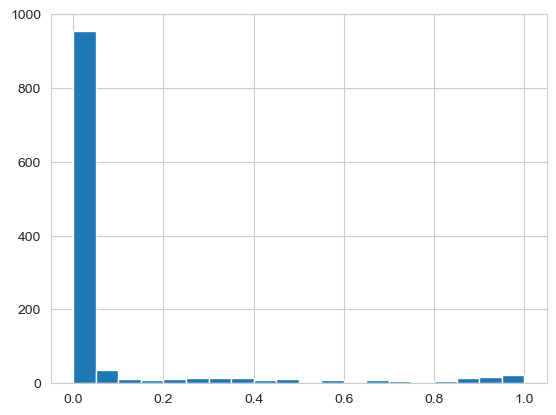

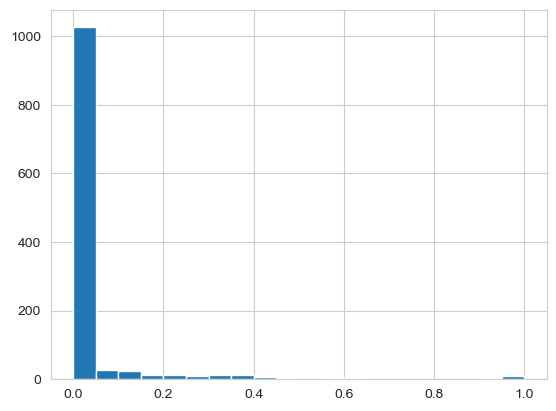

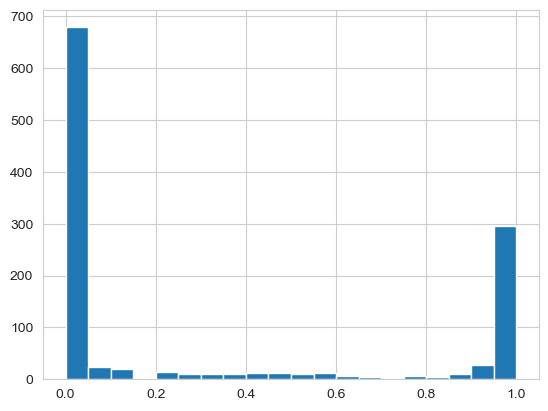

In [68]:
plt.hist(est_freq_R, bins = 20)
plt.show()
plt.hist(est_freq_H, bins = 20)
plt.show()
plt.hist(est_freq_A, bins = 20)
plt.show()